<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_AE/LSTM_AE_EURUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 6.33 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Jul 15 13:36:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'EURUSD'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 12.7MB/s 
     |████████████████████████████████| 174kB 51.3MB/s 
     |████████████████████████████████| 143kB 51.8MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(LSTM(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(LSTM(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: g2d1ortn
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_AE/sweeps/g2d1ortn


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: kiyk2z1j with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
32/32 [==============================] - 32s 237ms/step - loss: 258105419468.0089 - mean_squared_error: 258105419468.0089 - mean_absolute_error: 38210.8326 - val_loss: 0.1948 - val_mean_squared_error: 0.1948 - val_mean_absolute_error: 0.3547
Epoch 2/50
32/32 [==============================] - 6s 186ms/step - loss: 0.1411 - mean_squared_error: 0.1411 - mean_absolute_error: 0.2533 - val_loss: 0.1361 - val_mean_squared_error: 0.1361 - val_mean_absolute_error: 0.2849
Epoch 3/50
32/32 [==============================] - 6s 173ms/step - loss: 0.0773 - mean_squared_error: 0.0773 - mean_absolute_error: 0.1947 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - val_mean_absolute_error: 0.2643
Epoch 4/50
32/32 [==============================] - 6s 178ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - mean_absolute_error: 0.1687 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1489
Epoch 5/50
32/32 [==============================] - 6s 185ms/step - l

wandb: Agent Starting Run: pjqff8xl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 15s 243ms/step - loss: 0.1141 - mean_squared_error: 0.1141 - mean_absolute_error: 0.2394 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0852
Epoch 2/50
32/32 [==============================] - 6s 190ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0685 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0746
Epoch 3/50
32/32 [==============================] - 6s 186ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0604 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0874
Epoch 4/50
32/32 [==============================] - 6s 190ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0529 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0785
Epoch 5/50
32/32 [==============================] - 6s 178ms/step - loss: 0.0052 - mean_squared

wandb: Agent Starting Run: x1cyd7ua with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 10s 62ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - mean_absolute_error: 0.2348 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0900
Epoch 2/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0610 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0565
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0433 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0530
Epoch 4/100
32/32 [==============================] - 0s 16ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0397 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0526
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0030 - mean_squared

wandb: Agent Starting Run: 2562n5h8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 11s 292ms/step - loss: 0.1287 - mean_squared_error: 0.1287 - mean_absolute_error: 0.2612 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0851
Epoch 2/200
16/16 [==============================] - 3s 193ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0715 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0630
Epoch 3/200
16/16 [==============================] - 3s 191ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0528 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0619
Epoch 4/200
16/16 [==============================] - 3s 185ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0529 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0840
Epoch 5/200
16/16 [==============================] - 3s 190ms/step - loss: 0.0146 - mean_sq

wandb: Agent Starting Run: 4qfvwnaw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 8s 60ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1408 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0656
Epoch 2/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0646 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0649
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0631 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0913
Epoch 4/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0606 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0578
Epoch 5/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0043 - mean_squared_error

wandb: Agent Starting Run: urub8uq4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 8s 57ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1455 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0600
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0422 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0589
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0388 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0544
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0407 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0659
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0029 - mean_squared_

wandb: Agent Starting Run: qbxfyui9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 14s 259ms/step - loss: 0.1026 - mean_squared_error: 0.1026 - mean_absolute_error: 0.2270 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0632
Epoch 2/50
32/32 [==============================] - 6s 195ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0611 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0745
Epoch 3/50
32/32 [==============================] - 6s 191ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0496 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0623
Epoch 4/50
32/32 [==============================] - 6s 190ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0431 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0570
Epoch 5/50
32/32 [==============================] - 6s 190ms/step - loss: 0.0039 - mean_squared

wandb: Agent Starting Run: uh7mvak2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 78ms/step - loss: 0.5059 - mean_squared_error: 0.5059 - mean_absolute_error: 0.3103 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1220
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1081 - val_loss: 0.0957 - val_mean_squared_error: 0.0957 - val_mean_absolute_error: 0.2262
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0507 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1603 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1100
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1115 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0768
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0077 - mean_squared_

wandb: Processing terminal ouput (stdout)...
wandb: Done.


wandb: Agent Starting Run: 0nsjya6a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 8s 235ms/step - loss: 6.7479 - mean_squared_error: 6.7479 - mean_absolute_error: 1.3980 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0956
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0841 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0707
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1097 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0806
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_error: 0.1140 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1287
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0208 - mean_squared_error: 0.

wandb: Agent Starting Run: qhx1kwka with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 235ms/step - loss: 0.1406 - mean_squared_error: 0.1406 - mean_absolute_error: 0.2738 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0880
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0720 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0767
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0567 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0830
Epoch 4/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0701 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0700
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0057 - mean_squared_error: 0.0057 

wandb: Agent Starting Run: lrqhij9i with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 10s 451ms/step - loss: 44783937361454.9219 - mean_squared_error: 44783937361454.9219 - mean_absolute_error: 416203.7097 - val_loss: 0.0666 - val_mean_squared_error: 0.0666 - val_mean_absolute_error: 0.1957
Epoch 2/100
8/8 [==============================] - 2s 196ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - mean_absolute_error: 0.1683 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1530
Epoch 3/100
8/8 [==============================] - 2s 198ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1419 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1711
Epoch 4/100
8/8 [==============================] - 2s 201ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1341 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1264
Epoch 5/100
8/8 [==============================] - 2s 197ms/step - l

wandb: Agent Starting Run: xmeh05ii with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 13s 334ms/step - loss: 0.1654 - mean_squared_error: 0.1654 - mean_absolute_error: 0.3120 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1108
Epoch 2/200
16/16 [==============================] - 4s 221ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0850 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0865
Epoch 3/200
16/16 [==============================] - 3s 206ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0676 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0861
Epoch 4/200
16/16 [==============================] - 3s 193ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0553 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0714
Epoch 5/200
16/16 [==============================] - 3s 198ms/step - loss: 0.0050 - mean_sq

wandb: Agent Starting Run: udpgaflr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 15s 249ms/step - loss: 0.1044 - mean_squared_error: 0.1044 - mean_absolute_error: 0.2162 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0696
Epoch 2/200
32/32 [==============================] - 6s 193ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0681 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0595
Epoch 3/200
32/32 [==============================] - 6s 196ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0530 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0676
Epoch 4/200
32/32 [==============================] - 7s 204ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0475 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0542
Epoch 5/200
32/32 [==============================] - 7s 207ms/step - loss: 0.0032 - mean_sq

wandb: Agent Starting Run: ifyl2tbx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 8s 236ms/step - loss: 0.1113 - mean_squared_error: 0.1113 - mean_absolute_error: 0.2272 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0925
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0715 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1350
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0787 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0874
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0610 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0785
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0064 - mean_squared_error: 0.

wandb: Agent Starting Run: gyyfvyyp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 14s 239ms/step - loss: 0.1485 - mean_squared_error: 0.1485 - mean_absolute_error: 0.2844 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0762
Epoch 2/50
32/32 [==============================] - 6s 193ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0785 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0841
Epoch 3/50
32/32 [==============================] - 6s 190ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0567 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0650
Epoch 4/50
32/32 [==============================] - 6s 192ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0478 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0640
Epoch 5/50
32/32 [==============================] - 6s 197ms/step - loss: 0.0042 - mean_squared

wandb: Agent Starting Run: q3a94fc5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 10s 428ms/step - loss: 0.1769 - mean_squared_error: 0.1769 - mean_absolute_error: 0.3264 - val_loss: 0.1595 - val_mean_squared_error: 0.1595 - val_mean_absolute_error: 0.3102
Epoch 2/50
8/8 [==============================] - 2s 202ms/step - loss: 0.0928 - mean_squared_error: 0.0928 - mean_absolute_error: 0.2117 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1765
Epoch 3/50
8/8 [==============================] - 2s 200ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1776 - val_loss: 0.0355 - val_mean_squared_error: 0.0355 - val_mean_absolute_error: 0.1415
Epoch 4/50
8/8 [==============================] - 2s 193ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolute_error: 0.1142 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0796
Epoch 5/50
8/8 [==============================] - 2s 198ms/step - loss: 0.0125 - mean_squared_error: 0.

wandb: Agent Starting Run: ohjufbzo with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 9s 407ms/step - loss: 0.2936 - mean_squared_error: 0.2936 - mean_absolute_error: 0.3627 - val_loss: 0.0524 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1763
Epoch 2/50
8/8 [==============================] - 2s 221ms/step - loss: 0.1961 - mean_squared_error: 0.1961 - mean_absolute_error: 0.2097 - val_loss: 0.0580 - val_mean_squared_error: 0.0580 - val_mean_absolute_error: 0.1978
Epoch 3/50
8/8 [==============================] - 2s 193ms/step - loss: 34292992.0695 - mean_squared_error: 34292992.0695 - mean_absolute_error: 375.4790 - val_loss: 0.0913 - val_mean_squared_error: 0.0913 - val_mean_absolute_error: 0.2641
Epoch 4/50
8/8 [==============================] - 2s 199ms/step - loss: 0.1106 - mean_squared_error: 0.1106 - mean_absolute_error: 0.2478 - val_loss: 0.0890 - val_mean_squared_error: 0.0890 - val_mean_absolute_error: 0.2173
Epoch 5/50
8/8 [==============================] - 2s 205ms/step - loss: 275607994419.384

wandb: Agent Starting Run: z1ktpok8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 10s 292ms/step - loss: 0.1468 - mean_squared_error: 0.1468 - mean_absolute_error: 0.2832 - val_loss: 0.0384 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1449
Epoch 2/200
16/16 [==============================] - 3s 190ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0920 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0599
Epoch 3/200
16/16 [==============================] - 3s 189ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0486 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0560
Epoch 4/200
16/16 [==============================] - 3s 190ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0407 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0583
Epoch 5/200
16/16 [==============================] - 3s 208ms/step - loss: 0.0028 - mean_sq

wandb: Agent Starting Run: ryny1c09 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 11s 329ms/step - loss: 3565715541.1844 - mean_squared_error: 3565715541.1844 - mean_absolute_error: 5118.0685 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1473
Epoch 2/100
16/16 [==============================] - 3s 197ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1103 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0756
Epoch 3/100
16/16 [==============================] - 3s 204ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0768 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0707
Epoch 4/100
16/16 [==============================] - 3s 210ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0691 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0729
Epoch 5/100
16/16 [==============================] - 3s 201ms/step - l

wandb: Agent Starting Run: ipngtvcm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 9s 64ms/step - loss: 1.1336 - mean_squared_error: 1.1336 - mean_absolute_error: 0.4315 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0792
Epoch 2/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0485 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0900
Epoch 3/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0511 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0593
Epoch 4/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0400 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0813
Epoch 5/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0036 - mean_squared_error

wandb: Agent Starting Run: xl4f1di9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 113ms/step - loss: 0.6418 - mean_squared_error: 0.6418 - mean_absolute_error: 0.4417 - val_loss: 0.0479 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1719
Epoch 2/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0859 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0635
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0510 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0618
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0430 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0568
Epoch 5/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0027 - mean_squared

wandb: Agent Starting Run: qk9a6c4n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 8s 232ms/step - loss: 0.2107 - mean_squared_error: 0.2107 - mean_absolute_error: 0.3620 - val_loss: 0.1735 - val_mean_squared_error: 0.1735 - val_mean_absolute_error: 0.3261
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0951 - mean_squared_error: 0.0951 - mean_absolute_error: 0.2117 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1442
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0821 - mean_squared_error: 0.0821 - mean_absolute_error: 0.2075 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1640
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0484 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1702 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1508
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0265 - mean_squared_error: 0.

wandb: Agent Starting Run: a0t2gfkn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 11s 308ms/step - loss: 0.2982 - mean_squared_error: 0.2982 - mean_absolute_error: 0.3174 - val_loss: 0.4186 - val_mean_squared_error: 0.4186 - val_mean_absolute_error: 0.4290
Epoch 2/100
16/16 [==============================] - 3s 184ms/step - loss: 0.2227 - mean_squared_error: 0.2227 - mean_absolute_error: 0.2526 - val_loss: 0.0476 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1636
Epoch 3/100
16/16 [==============================] - 3s 201ms/step - loss: 4.9420 - mean_squared_error: 4.9420 - mean_absolute_error: 0.3910 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1216
Epoch 4/100
16/16 [==============================] - 3s 211ms/step - loss: 0.0259 - mean_squared_error: 0.0259 - mean_absolute_error: 0.1229 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0791
Epoch 5/100
16/16 [==============================] - 3s 199ms/step - loss: 0.0088 - mean_sq

wandb: Agent Starting Run: wmwexbvq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 14s 245ms/step - loss: 0.1401 - mean_squared_error: 0.1401 - mean_absolute_error: 0.2702 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1307
Epoch 2/100
32/32 [==============================] - 6s 192ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0950 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0917
Epoch 3/100
32/32 [==============================] - 6s 193ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0659 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0831
Epoch 4/100
32/32 [==============================] - 6s 191ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0530 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0905
Epoch 5/100
32/32 [==============================] - 6s 197ms/step - loss: 0.0043 - mean_sq

wandb: Agent Starting Run: ldngyss1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 10s 298ms/step - loss: 0.1959 - mean_squared_error: 0.1959 - mean_absolute_error: 0.3398 - val_loss: 0.1038 - val_mean_squared_error: 0.1038 - val_mean_absolute_error: 0.2408
Epoch 2/100
16/16 [==============================] - 3s 200ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1609 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1320
Epoch 3/100
16/16 [==============================] - 3s 187ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.1009 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0840
Epoch 4/100
16/16 [==============================] - 3s 205ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0605 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0645
Epoch 5/100
16/16 [==============================] - 3s 194ms/step - loss: 0.0050 - mean_sq

wandb: Agent Starting Run: 4cqu2zwy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 11s 295ms/step - loss: 0.1563 - mean_squared_error: 0.1563 - mean_absolute_error: 0.2945 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0809
Epoch 2/100
16/16 [==============================] - 3s 209ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0679 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0987
Epoch 3/100
16/16 [==============================] - 3s 193ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0585 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0650
Epoch 4/100
16/16 [==============================] - 3s 196ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0503 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0732
Epoch 5/100
16/16 [==============================] - 3s 198ms/step - loss: 0.0059 - mean_sq

wandb: Agent Starting Run: kghfetv7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 8s 233ms/step - loss: 1.2364 - mean_squared_error: 1.2364 - mean_absolute_error: 0.6111 - val_loss: 0.1120 - val_mean_squared_error: 0.1120 - val_mean_absolute_error: 0.2640
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1372 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0901
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0903 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0700
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0526 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0946
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0118 - mean_squared_error: 0.

wandb: Agent Starting Run: tooih4ny with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 9s 64ms/step - loss: 0.1303 - mean_squared_error: 0.1303 - mean_absolute_error: 0.2549 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1335
Epoch 2/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0656 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0611
Epoch 3/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0491 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0567
Epoch 4/200
32/32 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0481 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0747
Epoch 5/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0049 - mean_squared_

wandb: Agent Starting Run: aftxux84 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 228ms/step - loss: 0.1177 - mean_squared_error: 0.1177 - mean_absolute_error: 0.2461 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0821
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0705 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0660
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0527 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0853
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0711 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0779
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0060 - mean_squared_error: 0.0060 

wandb: Agent Starting Run: 84c61qaj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 8s 114ms/step - loss: 0.0945 - mean_squared_error: 0.0945 - mean_absolute_error: 0.2108 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0688
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0596 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1122
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0677 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0712
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0517 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0623
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0039 - mean_squared

wandb: Agent Starting Run: e0x7g36l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 229ms/step - loss: 0.0991 - mean_squared_error: 0.0991 - mean_absolute_error: 0.2199 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0759
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0623 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0652
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0584 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0702
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0588 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0700
Epoch 5/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0078 - mean_squared_error: 0.0078 

wandb: Agent Starting Run: 7w6d7qpm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 8s 120ms/step - loss: 0.0912 - mean_squared_error: 0.0912 - mean_absolute_error: 0.2086 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0721
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0663 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0802
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0814 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1455
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0746 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1167
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0084 - mean_squared_erro

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 1266, in agent_heartbeat
    timeout=60,
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/lib/retry.py", line 102, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 127, in execute
    return self.client.execute(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 52, in execute
    result = self._get_result(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 60, in _get_result
    return self.transport.execute(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/transport/requests.py", line 38, in execute
    request = requests.post(self.url, **post_args)
  File "/u

# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [32]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'dropout': 0.1,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [33]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(LSTM(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(LSTM(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  247937


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [35]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
40/40 [==============================] - 5s 10ms/step - loss: 0.0414
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 4/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 5/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 6/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 7/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 8/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 9/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 10/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 11/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 12/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 13/100
40/40 [=========

In [36]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

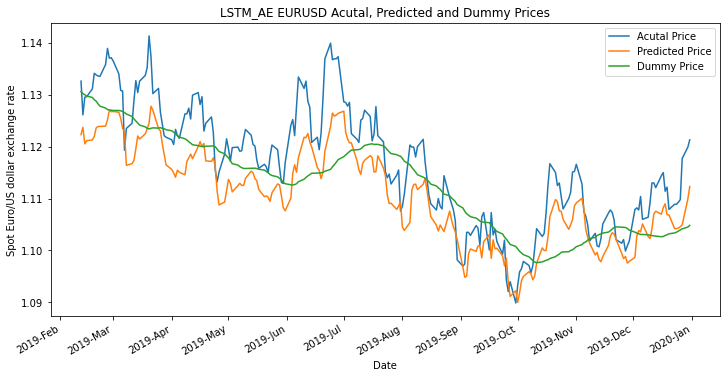

In [37]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

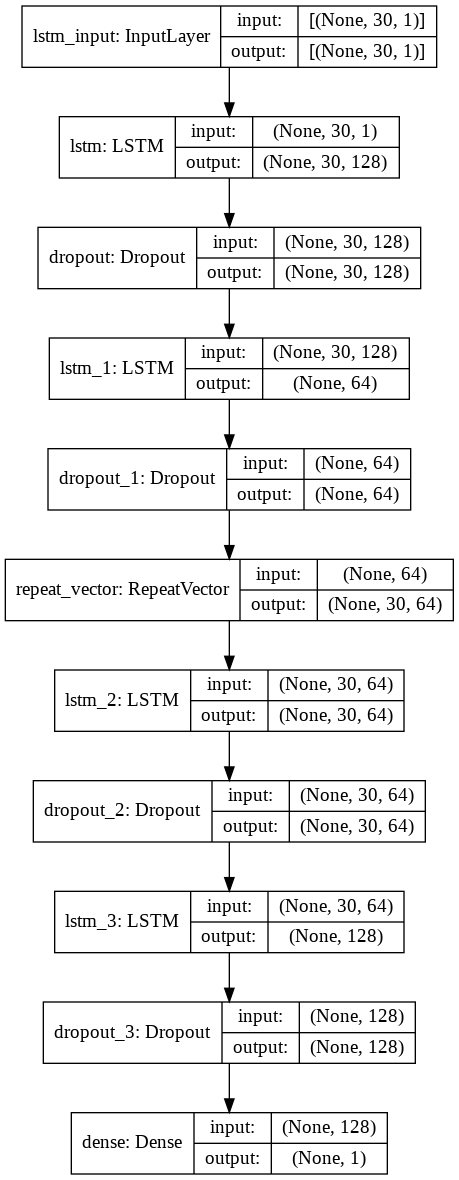

In [38]:
plot_model(model, show_shapes=True, expand_nested=True)

In [39]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.019352720157078715
RMSE:  0.13911405449155279
MAE:  0.1202870778684094
Dummy MSE:  0.0236885518332631
Dummy RMSE:  0.15391085677515767
Dummy MAE:  0.11970302826636056


In [40]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_EURUSD/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_EURUSD/assets
